In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

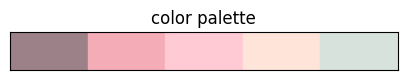

In [2]:
c_pal = ['#9d8189', '#f4acb7', '#ffcad4', '#ffe5d9', '#d8e2dc']

fig, ax = plt.subplots(figsize=(5, 0.5))

for i, color in enumerate(c_pal):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=color))

ax.set_xlim(0, len(c_pal))
ax.set_ylim(0, 1)

ax.set_xticks([])
ax.set_yticks([])

plt.title('color palette')

plt.show();

In [3]:
data = pd.read_csv('data/plaenterwaldlauf.csv')

In [4]:
data = data.drop(['Unnamed: 0'], axis=1)

In [5]:
data

,Startnr.,AK,Platz AK,Verein,Bruttozeit,Nettozeit,Strecke
0,605,M 20,1,TuS Kreuzweingarten-Rheder,17:16 min,(17:15),5
1,666,M 40,1,LG Mauerweg Berlin e.V.,17:56 min,(17:55),5
2,1083,M 30,1,BSV Friesen,18:07 min,(18:05),5
3,643,M 20,2,TuS Neukölln Berlin,18:12 min,(17:55),5
4,601,M 35,1,TVB 09,18:43 min,(18:27),5
...,...,...,...,...,...,...,...
682,93,W 50,1,LG Mauerweg Berlin e.V.,2:15:13 h,(2:14:43),20
683,57,W 20,7,Berlin,2:19:10 h,(2:17:41),20
684,109,W 60,2,Berlin,2:22:25 h,(2:22:03),20
685,13,W 20,8,Steglitz,2:27:21 h,(2:25:27),20
